# 2주차
- E-commerce dataset: popular index regression

## 데이터 이해
- Product ID: 상품 구분 아이디
- Product Name: 게시된 상품의 이름
- Category:: 상품 카테고리 (Electronics, Clothing, Home Decor ..)
- Price: 상품 가격
- Discount: 상품에 적용된 할인율 (%)
- Tax Rate: 상품에 적용된 세율 (%)
- Stock Level: 이용가능한 재고 수준
- Supplier ID: 상품 공급자 구분 아이디
- Customer Age Group: 상품을 구매한 고객의 나이대
- Customer Location: 고객의 지리학적 위치 (Country, State, City ..)
- Customer Gender: 고객 성별 
- Shipping Cost: 배송비 (USD) 
- Shipping Method: 배송방법 (Standard, Express, Overnight ..)
- Return Rate: 반품율 (%)
- Seasonality: 상품이 인기가 많았던 계절 (Winter, Summer ..)
- Popularity Index: 상품의 인기도 (0~100)

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
from datetime import datetime

# preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer

# validation
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score

# valuation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import make_scorer

# modeling
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# etc 
import warnings
warnings.filterwarnings(action='ignore')

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
# 데이터 불러오기
df = pd.read_csv("C:/Users/sssum/Downloads/diversified_ecommerce_dataset.csv")
df.head()

,Product ID,Product Name,Category,Price,Discount,Tax Rate,Stock Level,Supplier ID,Customer Age Group,Customer Location,Customer Gender,Shipping Cost,Shipping Method,Return Rate,Seasonality,Popularity Index
0,P6879,Jacket,Apparel,53.85,5,15,150,S535,35-44,"New York, USA",Male,23.32,Standard,4.49,Yes,56
1,P5132,Camera,Electronics,761.26,10,15,224,S583,25-34,"London, UK",Female,20.88,Overnight,16.11,No,79
2,P2941,Sneakers,Footwear,1756.76,5,8,468,S118,25-34,"Tokyo, Japan",Non-Binary,16.43,Standard,4.93,No,40
3,P8545,Cookbooks,Books,295.24,10,15,25,S104,18-24,"Paris, France",Female,27.49,Standard,1.31,No,93
4,P4594,Camera,Electronics,832.00,10,12,340,S331,55+,"Tokyo, Japan",Male,45.93,Overnight,4.37,No,56


In [3]:
# 데이터 기본 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Product ID          1000000 non-null  object 
 1   Product Name        1000000 non-null  object 
 2   Category            1000000 non-null  object 
 3   Price               1000000 non-null  float64
 4   Discount            1000000 non-null  int64  
 5   Tax Rate            1000000 non-null  int64  
 6   Stock Level         1000000 non-null  int64  
 7   Supplier ID         1000000 non-null  object 
 8   Customer Age Group  1000000 non-null  object 
 9   Customer Location   1000000 non-null  object 
 10  Customer Gender     1000000 non-null  object 
 11  Shipping Cost       1000000 non-null  float64
 12  Shipping Method     1000000 non-null  object 
 13  Return Rate         1000000 non-null  float64
 14  Seasonality         1000000 non-null  object 
 15  Popularity Index

현재 결측치가 없다고 보이지만, 각 속성의 실제값을 확인해야 함.

In [4]:
# 데이터 통계정보 확인 - 수치형
df.describe()

,Price,Discount,Tax Rate,Stock Level,Shipping Cost,Return Rate,Popularity Index
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1005.120742,12.516955,10.002052,250.028536,24.985224,10.492896,49.970211
std,574.451223,8.539929,3.406026,144.676275,14.431730,5.484849,29.164875
min,10.000000,0.000000,5.000000,0.000000,0.000000,1.000000,0.000000
25%,507.860000,5.000000,8.000000,125.000000,12.490000,5.740000,25.000000
50%,1005.430000,15.000000,10.000000,250.000000,24.970000,10.480000,50.000000
75%,1502.310000,20.000000,12.000000,375.000000,37.470000,15.250000,75.000000
max,2000.000000,25.000000,15.000000,500.000000,50.000000,20.000000,100.000000


평균과 표준편차가 거의 동일한 속성은 없음. 범주를 모아주는 작업은 필요하지 않음을 알 수 있음. 하지만 각 값들의 범위가 크게 달라서 모델링에 영향을 줄 수 있으므로 스케일링 작업은 필요함. 전처리 파트에서 진행할 예정.

In [5]:
# 데이터 통계정보 확인 - 범주형
df.describe(include='object')

,Product ID,Product Name,Category,Supplier ID,Customer Age Group,Customer Location,Customer Gender,Shipping Method,Seasonality
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,9000,43,5,900,5,15,3,3,2
top,P2639,Graphic Novels,Books,S912,18-24,"Dubai, UAE",Male,Standard,No
freq,150,25396,200751,1226,200345,67253,333791,333451,500203


seasonality 속성값이 데이터 정의와 다르게 들어가있음.

In [6]:
# 범주형 속성 값 확인
print(df['Category'].value_counts())
print(df['Customer Age Group'].value_counts())
print(df['Customer Location'].value_counts())

Books              200751
Electronics        200231
Footwear           200089
Home Appliances    199708
Apparel            199221
Name: Category, dtype: int64
18-24    200345
25-34    200313
35-44    200076
45-54    199937
55+      199329
Name: Customer Age Group, dtype: int64
Dubai, UAE                 67253
Cape Town, South Africa    67153
Houston, USA               67048
Mumbai, India              66912
Chicago, USA               66864
Singapore                  66802
London, UK                 66715
Tokyo, Japan               66618
Phoenix, USA               66604
Toronto, Canada            66559
Los Angeles, USA           66507
New York, USA              66463
Sydney, Australia          66334
Berlin, Germany            66086
Paris, France              66082
Name: Customer Location, dtype: int64


In [7]:
# 범주형 속성 값 확인
print(df['Customer Gender'].value_counts())
print(df['Shipping Method'].value_counts())
print(df['Seasonality'].value_counts())

Male          333791
Non-Binary    333541
Female        332668
Name: Customer Gender, dtype: int64
Standard     333451
Express      333275
Overnight    333274
Name: Shipping Method, dtype: int64
No     500203
Yes    499797
Name: Seasonality, dtype: int64


값이 없다고 표시된 것은 없음을 확인함.

## EDA

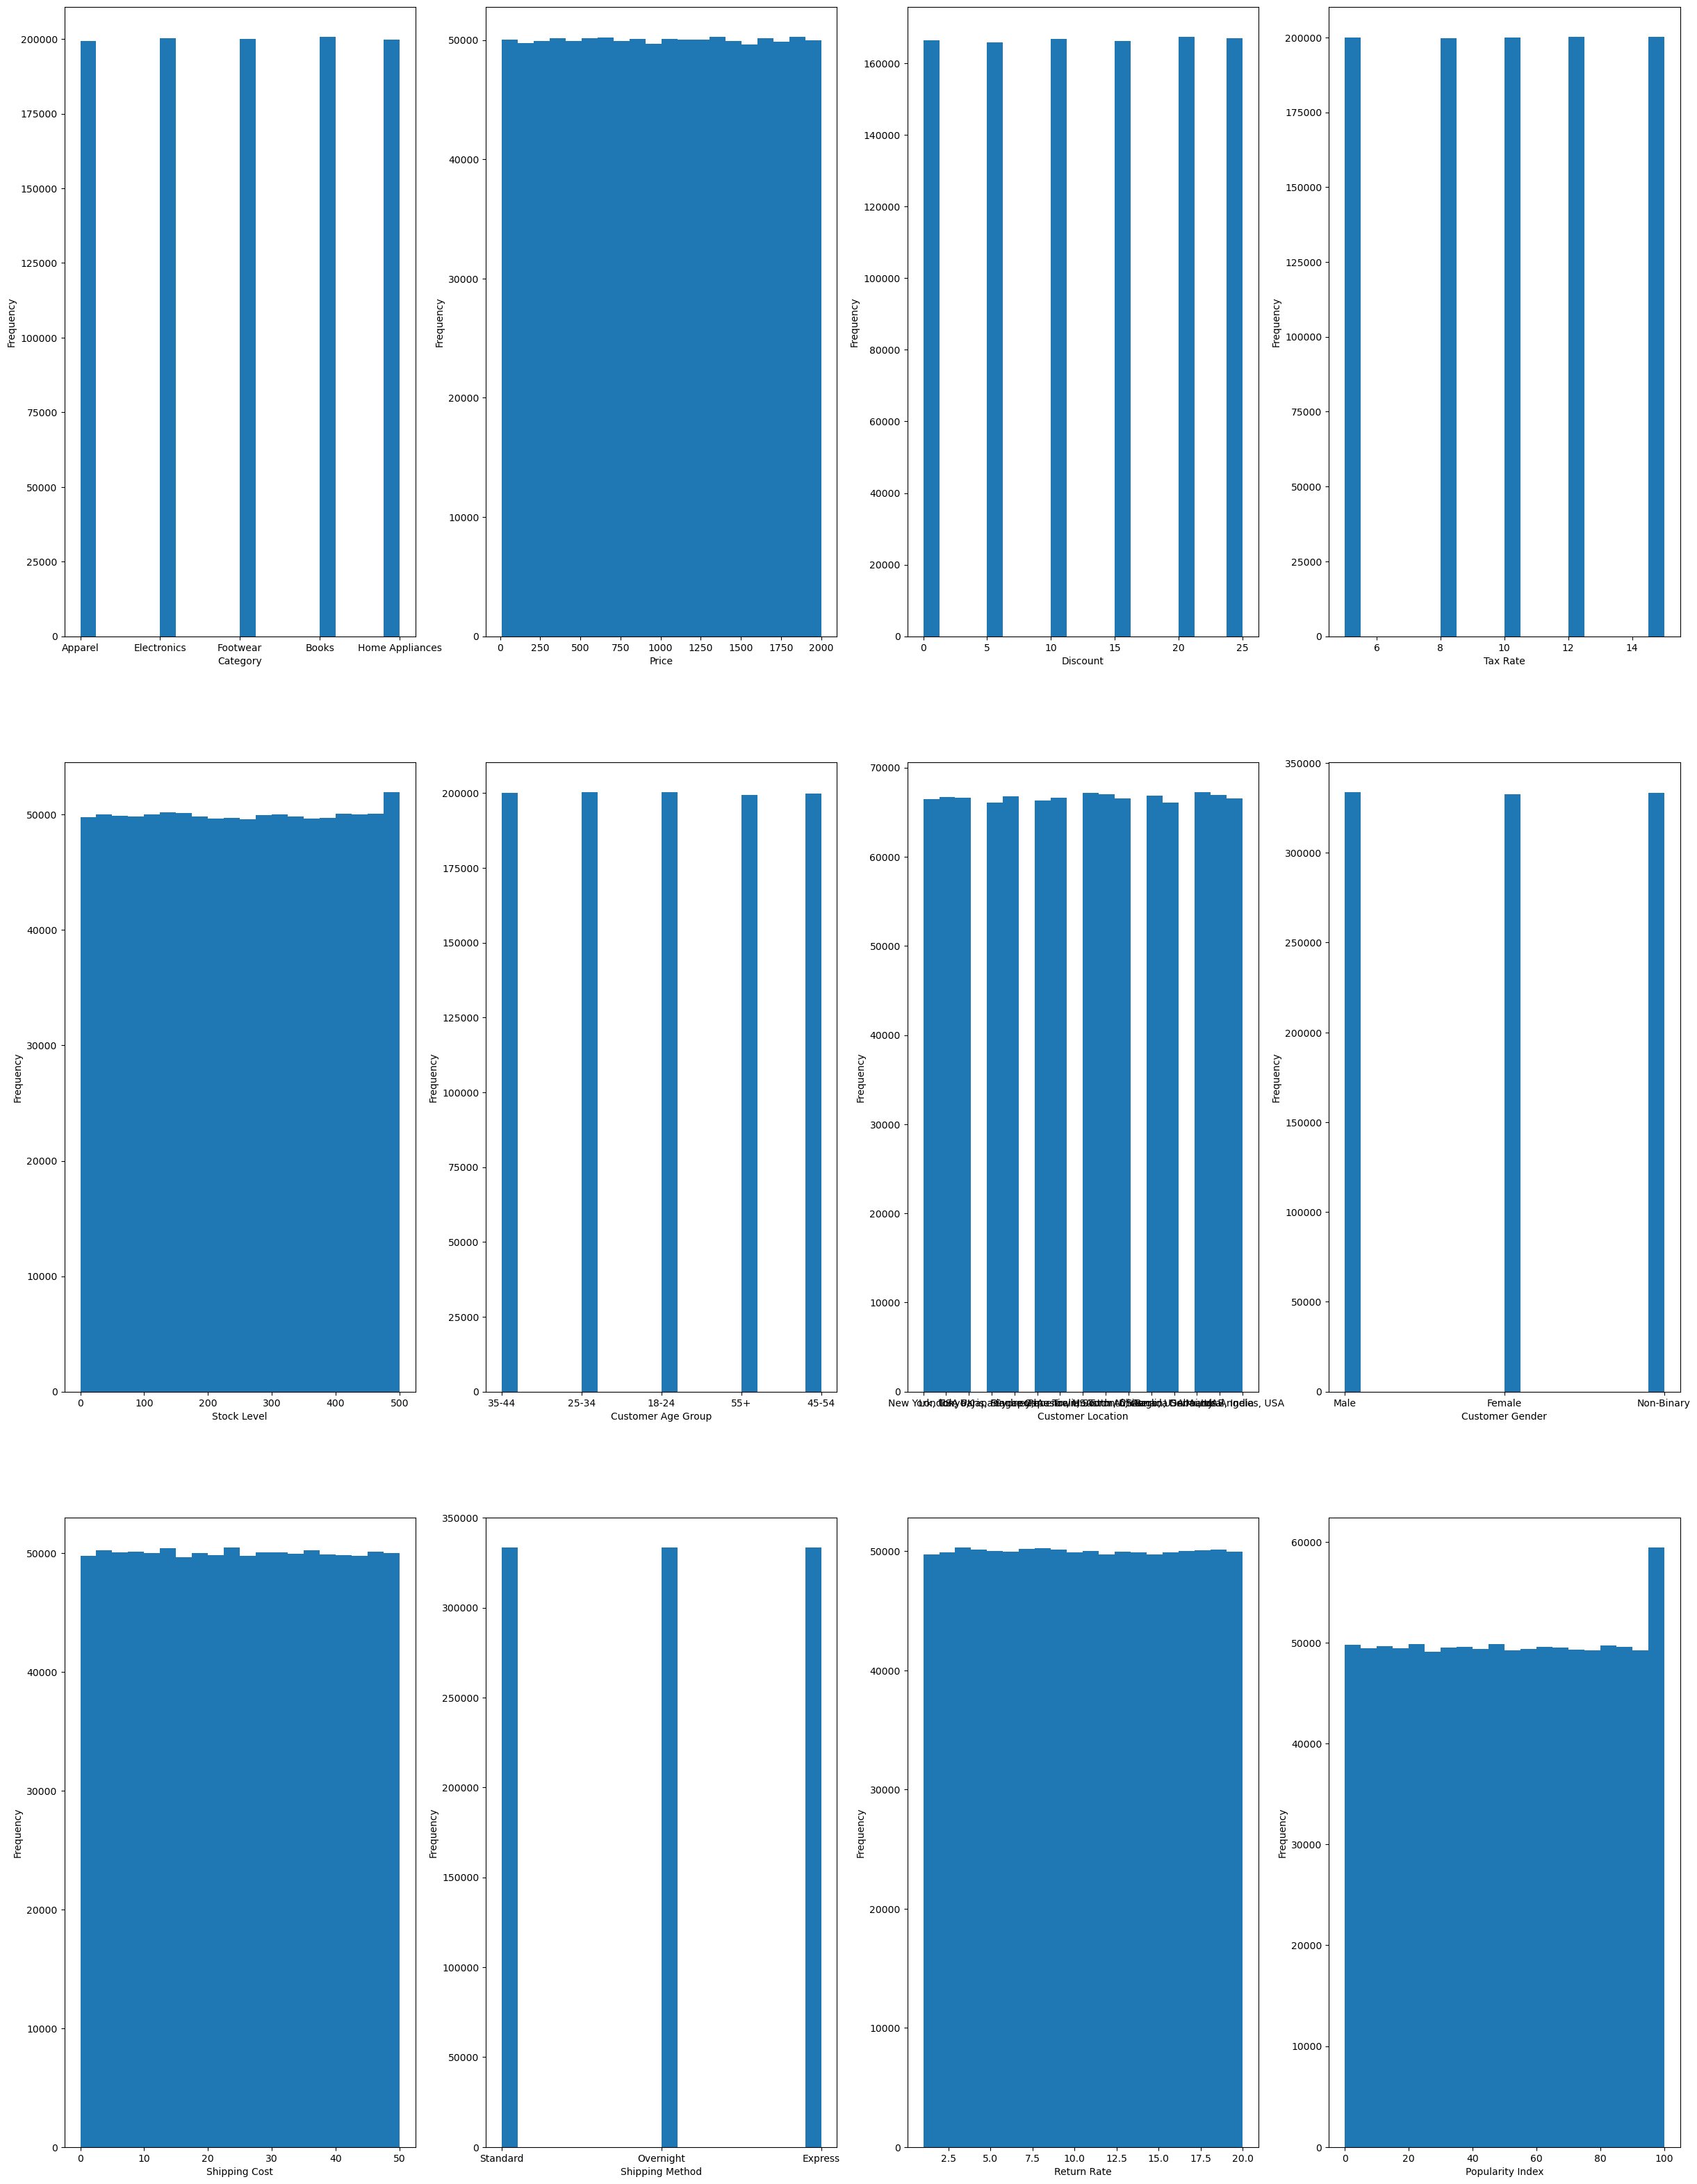

In [8]:
# 속성 분포 확인 - 고유값 제외 (Customer ID, Supplier ID, Product Name)
col = ['Category', 'Price', 'Discount', 'Tax Rate', 'Stock Level', 'Customer Age Group', 'Customer Location', 'Customer Gender', 'Shipping Cost', 'Shipping Method', 
       'Return Rate', 'Popularity Index']

fig, ax = plt.subplots(3, 4, figsize=(30, 40))

idx = 0
for i in range(3): # subplot 행
    for j in range(4): # subplot 열
        colname = list(col)[idx]
        ax[i][j].hist(df[colname], bins=20)
        ax[i][j].set_xlabel(colname)
        ax[i][j].set_ylabel('Frequency')
        
        idx += 1

타겟변수인 Popularity Index를 제외한 다른 속성들은 고른 분포를 가지고 있음을 확인함.

array([[<Axes: xlabel='Price', ylabel='Price'>,
        <Axes: xlabel='Discount', ylabel='Price'>,
        <Axes: xlabel='Tax Rate', ylabel='Price'>,
        <Axes: xlabel='Stock Level', ylabel='Price'>,
        <Axes: xlabel='Shipping Cost', ylabel='Price'>,
        <Axes: xlabel='Return Rate', ylabel='Price'>,
        <Axes: xlabel='Popularity Index', ylabel='Price'>],
       [<Axes: xlabel='Price', ylabel='Discount'>,
        <Axes: xlabel='Discount', ylabel='Discount'>,
        <Axes: xlabel='Tax Rate', ylabel='Discount'>,
        <Axes: xlabel='Stock Level', ylabel='Discount'>,
        <Axes: xlabel='Shipping Cost', ylabel='Discount'>,
        <Axes: xlabel='Return Rate', ylabel='Discount'>,
        <Axes: xlabel='Popularity Index', ylabel='Discount'>],
       [<Axes: xlabel='Price', ylabel='Tax Rate'>,
        <Axes: xlabel='Discount', ylabel='Tax Rate'>,
        <Axes: xlabel='Tax Rate', ylabel='Tax Rate'>,
        <Axes: xlabel='Stock Level', ylabel='Tax Rate'>,
        <Axes: 

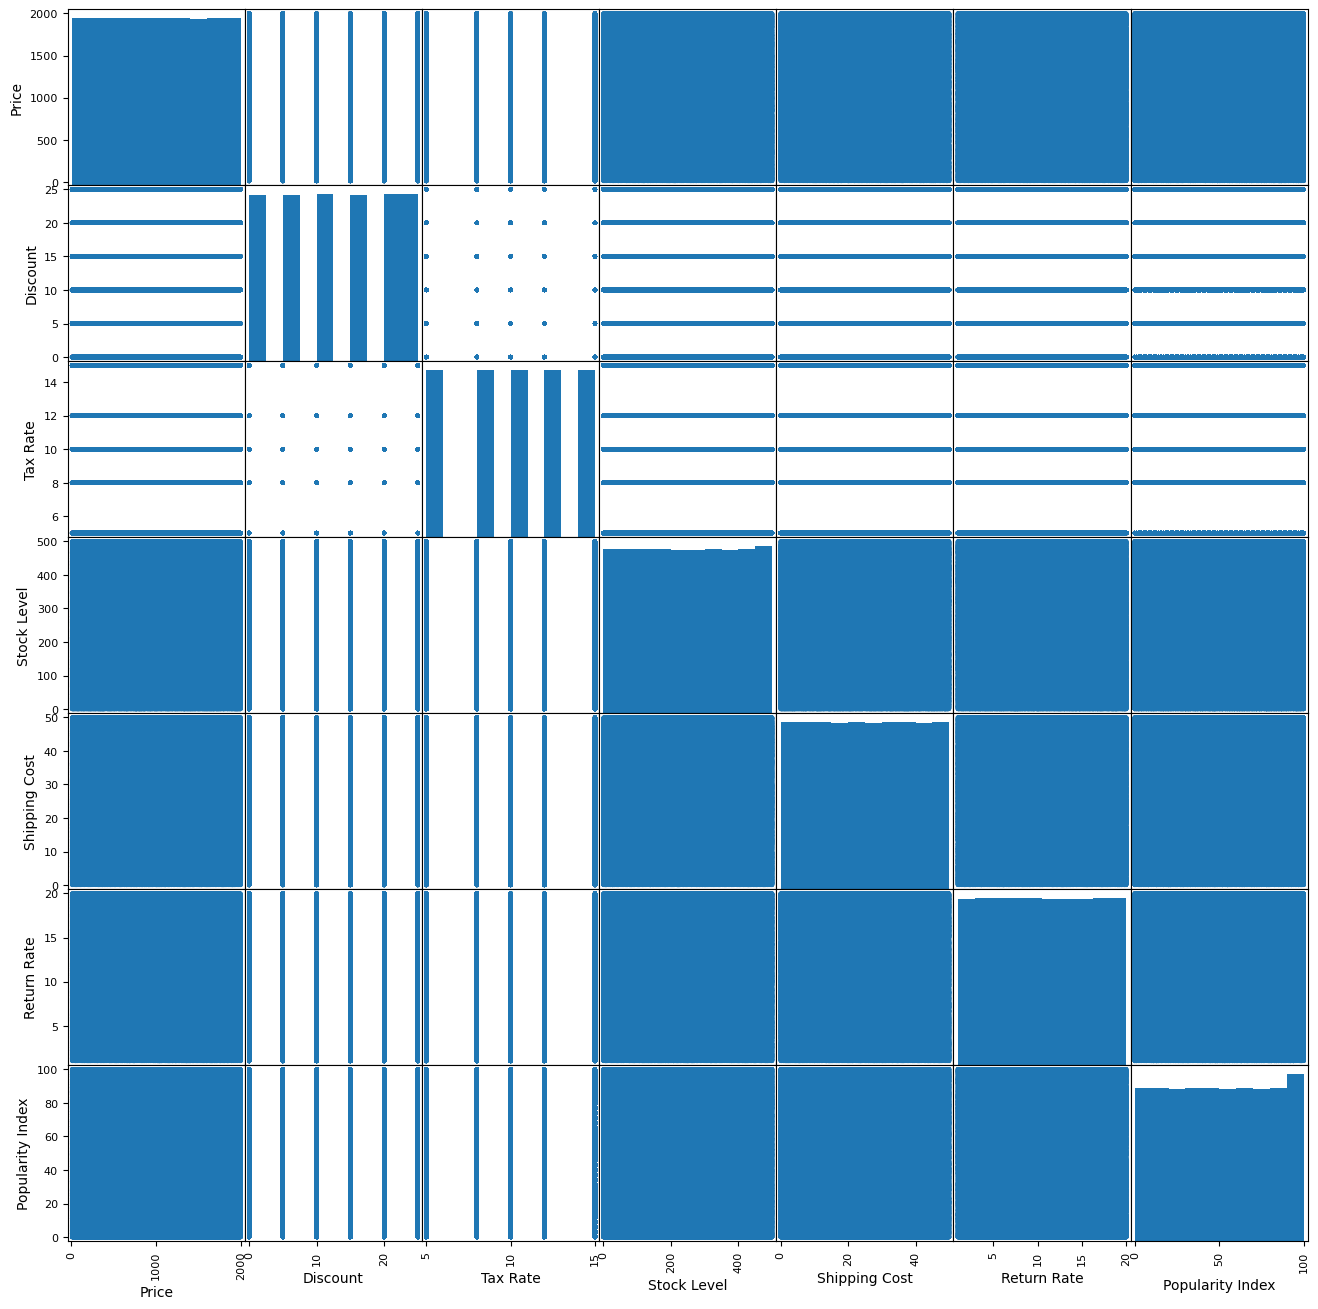

In [9]:
# 상관관계 확인
numeric_col = ['Price', 'Discount', 'Tax Rate', 'Stock Level', 'Shipping Cost', 'Return Rate', 'Popularity Index']
pd.plotting.scatter_matrix(df[numeric_col], figsize=(16, 16))

상관관계가 뚜렷하게 보이는 속성들은 없음.

In [10]:
# 컬럼간 상관관계 파악
df.corr()

,Price,Discount,Tax Rate,Stock Level,Shipping Cost,Return Rate,Popularity Index
Price,1.000000,0.000137,-0.000357,0.000213,-0.001758,-0.000405,-0.000233
Discount,0.000137,1.000000,0.001209,0.000425,0.001071,0.000381,0.001250
Tax Rate,-0.000357,0.001209,1.000000,0.001220,-0.000610,-0.001154,0.000660
Stock Level,0.000213,0.000425,0.001220,1.000000,-0.000811,-0.000190,0.000303
Shipping Cost,-0.001758,0.001071,-0.000610,-0.000811,1.000000,-0.000090,0.000519
Return Rate,-0.000405,0.000381,-0.001154,-0.000190,-0.000090,1.000000,0.001648
Popularity Index,-0.000233,0.001250,0.000660,0.000303,0.000519,0.001648,1.000000


컬럼 간 상관관계는 대부분 0.00xx으로 삭제해야할 변수는 없음.

<Axes: ylabel='Popularity Index'>

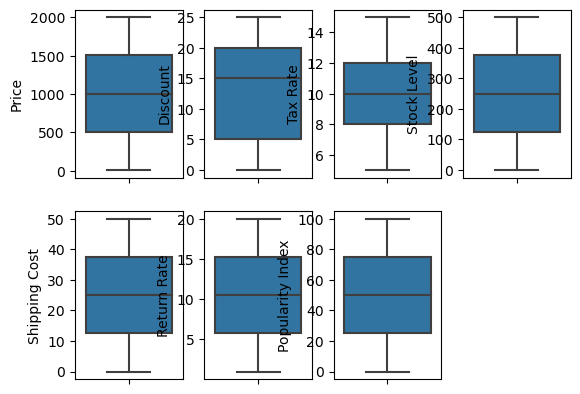

In [11]:
# 이상치 탐지
plt.subplot(2, 4, 1)
sns.boxplot(data=df, y='Price')
plt.subplot(2, 4, 2)
sns.boxplot(data=df, y='Discount')
plt.subplot(2, 4, 3)
sns.boxplot(data=df, y='Tax Rate')
plt.subplot(2, 4, 4)
sns.boxplot(data=df, y='Stock Level')
plt.subplot(2, 4, 5)
sns.boxplot(data=df, y='Shipping Cost')
plt.subplot(2, 4, 6)
sns.boxplot(data=df, y='Return Rate')
plt.subplot(2, 4, 7)
sns.boxplot(data=df, y='Popularity Index')

상자그림에서는 이상치가 발견되지 않음.

## 데이터 전처리

In [8]:
# 데이터 분할
X = df.drop(['Popularity Index', 'Seasonality', 'Product ID', 'Supplier ID', 'Product Name'], axis=1) # Seasonality 속성값이 설명과 달라서 일단 제거하고 진행, 예측에 크게 영향을 미치지 않는 ID 컬럼 제외
y = df['Popularity Index']

train_input, test_input, train_target, test_target = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# 분할 확인
print(train_input.shape)
print(test_input.shape)
print(train_target.shape)
print(test_target.shape)

(700000, 11)
(300000, 11)
(700000,)
(300000,)


In [10]:
# 표준화 			
cols = ['Price', 'Discount', 'Tax Rate', 'Stock Level', 'Shipping Cost', 'Return Rate']
for col in cols:
    std = StandardScaler()
    std.fit(train_input[[col]])
    train_input[col] = std.transform(train_input[[col]]).flatten()
    test_input[col] = std.transform(test_input[[col]]).flatten()
    
train_input.describe()

,Price,Discount,Tax Rate,Stock Level,Shipping Cost,Return Rate
count,7.000000e+05,7.000000e+05,7.000000e+05,7.000000e+05,7.000000e+05,7.000000e+05
mean,-3.479426e-16,-1.017649e-16,-1.217769e-16,1.089161e-17,7.642192e-16,-4.294571e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.732122e+00,-1.465766e+00,-1.466996e+00,-1.727558e+00,-1.731125e+00,-1.729591e+00
25%,-8.661924e-01,-8.802281e-01,-5.868254e-01,-8.640149e-01,-8.657566e-01,-8.656814e-01
50%,6.076800e-04,2.908486e-01,-4.526590e-05,-4.716821e-04,-1.774184e-03,-1.772141e-03
75%,8.660328e-01,8.763870e-01,5.867349e-01,8.699799e-01,8.663653e-01,8.657823e-01
max,1.731319e+00,1.461925e+00,1.466905e+00,1.726615e+00,1.733119e+00,1.733337e+00


In [11]:
# 범주형 변수 처리
train_input.describe(include='object')

,Category,Customer Age Group,Customer Location,Customer Gender,Shipping Method
count,700000,700000,700000,700000,700000
unique,5,5,15,3,3
top,Books,18-24,"Dubai, UAE",Non-Binary,Express
freq,140304,140361,47166,233471,233482


- get dummies: Category, Customer Gender, Shipping Method
- Label Encoder: Customer Age Group, Customer Location

In [12]:
# 더미코딩 - Category, Customer Gender, Shipping Method
train_input = pd.get_dummies(train_input, columns=['Category', 'Customer Gender', 'Shipping Method'])
test_input = pd.get_dummies(test_input, columns=['Category', 'Customer Gender', 'Shipping Method'])

train_input.head()

,Price,Discount,Tax Rate,Stock Level,Customer Age Group,Customer Location,Shipping Cost,Return Rate,Category_Apparel,Category_Books,Category_Electronics,Category_Footwear,Category_Home Appliances,Customer Gender_Female,Customer Gender_Male,Customer Gender_Non-Binary,Shipping Method_Express,Shipping Method_Overnight,Shipping Method_Standard
506532,-0.561880,1.461925,1.466905,-0.829473,55+,Singapore,1.543279,0.548651,0,1,0,0,0,0,0,1,0,0,1
327991,1.223986,-0.294690,-0.000045,0.047887,45-54,"London, UK",0.997314,-1.191926,0,0,0,1,0,1,0,0,0,0,1
715937,-1.199031,0.290849,0.586735,1.581540,18-24,"Berlin, Germany",1.340274,1.219365,0,1,0,0,0,0,1,0,0,0,1
860726,0.427220,-0.880228,-1.466996,1.194672,55+,"Houston, USA",-0.468754,-1.702252,1,0,0,0,0,0,1,0,1,0,0
78617,-1.001806,0.876387,1.466905,-0.180089,35-44,"Tokyo, Japan",0.291994,1.303205,0,0,0,0,1,1,0,0,0,0,1


In [13]:
# 레이블 인코딩 - Customer Age Group
label_age = LabelEncoder()
label_age.fit(train_input['Customer Age Group'])

train_input['Customer Age Group'] = label_age.transform(train_input['Customer Age Group'])
test_input['Customer Age Group'] = label_age.transform(test_input['Customer Age Group'])

train_input.head()

,Price,Discount,Tax Rate,Stock Level,Customer Age Group,Customer Location,Shipping Cost,Return Rate,Category_Apparel,Category_Books,Category_Electronics,Category_Footwear,Category_Home Appliances,Customer Gender_Female,Customer Gender_Male,Customer Gender_Non-Binary,Shipping Method_Express,Shipping Method_Overnight,Shipping Method_Standard
506532,-0.561880,1.461925,1.466905,-0.829473,4,Singapore,1.543279,0.548651,0,1,0,0,0,0,0,1,0,0,1
327991,1.223986,-0.294690,-0.000045,0.047887,3,"London, UK",0.997314,-1.191926,0,0,0,1,0,1,0,0,0,0,1
715937,-1.199031,0.290849,0.586735,1.581540,0,"Berlin, Germany",1.340274,1.219365,0,1,0,0,0,0,1,0,0,0,1
860726,0.427220,-0.880228,-1.466996,1.194672,4,"Houston, USA",-0.468754,-1.702252,1,0,0,0,0,0,1,0,1,0,0
78617,-1.001806,0.876387,1.466905,-0.180089,2,"Tokyo, Japan",0.291994,1.303205,0,0,0,0,1,1,0,0,0,0,1


In [14]:
# 레이블 인코딩 - Customer Location
label_location = LabelEncoder()
label_location.fit(train_input['Customer Location'])

train_input['Customer Location'] = label_location.transform(train_input['Customer Location'])
test_input['Customer Location'] = label_location.transform(test_input['Customer Location'])

train_input.head()

,Price,Discount,Tax Rate,Stock Level,Customer Age Group,Customer Location,Shipping Cost,Return Rate,Category_Apparel,Category_Books,Category_Electronics,Category_Footwear,Category_Home Appliances,Customer Gender_Female,Customer Gender_Male,Customer Gender_Non-Binary,Shipping Method_Express,Shipping Method_Overnight,Shipping Method_Standard
506532,-0.561880,1.461925,1.466905,-0.829473,4,11,1.543279,0.548651,0,1,0,0,0,0,0,1,0,0,1
327991,1.223986,-0.294690,-0.000045,0.047887,3,5,0.997314,-1.191926,0,0,0,1,0,1,0,0,0,0,1
715937,-1.199031,0.290849,0.586735,1.581540,0,0,1.340274,1.219365,0,1,0,0,0,0,1,0,0,0,1
860726,0.427220,-0.880228,-1.466996,1.194672,4,4,-0.468754,-1.702252,1,0,0,0,0,0,1,0,1,0,0
78617,-1.001806,0.876387,1.466905,-0.180089,2,13,0.291994,1.303205,0,0,0,0,1,1,0,0,0,0,1


## 모델링
- Linear Regression
- CatBoostRegressor
- XGBRegressor
- LGBMRegressor

In [15]:
# 데이터 확인
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(700000, 19) (700000,)
(300000, 19) (300000,)


In [16]:
train_input.columns

Index(['Price', 'Discount', 'Tax Rate', 'Stock Level', 'Customer Age Group',
       'Customer Location', 'Shipping Cost', 'Return Rate', 'Category_Apparel',
       'Category_Books', 'Category_Electronics', 'Category_Footwear',
       'Category_Home Appliances', 'Customer Gender_Female',
       'Customer Gender_Male', 'Customer Gender_Non-Binary',
       'Shipping Method_Express', 'Shipping Method_Overnight',
       'Shipping Method_Standard'],
      dtype='object')

In [17]:
# 사용할 모델 객체 선언
cat_list = ['Category_Apparel', 'Category_Books', 'Category_Electronics', 'Category_Footwear', 'Category_Home Appliances', 'Customer Gender_Female',
       'Customer Gender_Male', 'Customer Gender_Non-Binary', 'Shipping Method_Express', 'Shipping Method_Overnight', 'Shipping Method_Standard']
lr = LinearRegression()
cat = CatBoostRegressor(random_state=42, cat_features=cat_list)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)

models = [lr, cat, xgb, lgbm]

In [18]:
# 모델 rmse, mae 값 확인
for model in models:
    name = model.__class__.__name__
    mse_scores = cross_val_score(model, X=train_input, y=train_target, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1)
    mae_scores = cross_val_score(model, X=train_input, y=train_target, cv=5,
                             scoring='neg_mean_absolute_error', n_jobs=-1)
    rmse = np.sqrt((-1) * np.mean(mse_scores))
    mae = (-1) * np.mean(mae_scores)
    print('Model %s - RMSE: %.4f, MAE: %.4f' % (name, rmse, mae))

Model LinearRegression - RMSE: 29.1710, MAE: 25.2661
Model CatBoostRegressor - RMSE: 29.2171, MAE: 25.2933
Model XGBRegressor - RMSE: 29.2571, MAE: 25.3147
Model LGBMRegressor - RMSE: 29.1781, MAE: 25.2708


## 하이퍼 파라미터 튜닝

In [ ]:
# CatBoostRegressor 하이퍼 파라미터 튜닝
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cat_list = ['Category_Apparel', 'Category_Books', 'Category_Electronics', 'Category_Footwear', 'Category_Home Appliances', 'Customer Gender_Female',
       'Customer Gender_Male', 'Customer Gender_Non-Binary', 'Shipping Method_Express', 'Shipping Method_Overnight', 'Shipping Method_Standard']

cat_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 7, 11],
    'cat_features': [cat_list],
    'random_state': [42]
}

cat_search = GridSearchCV(cat, param_grid=cat_params, cv=5, scoring={
        'mse': mse_scorer,  # MSE 점수 계산
        'mae': mae_scorer   # MAE 점수 계산
    },
    refit='mse', n_jobs=-1)
cat_search.fit(train_input, train_target)
best_mse = (-1) * cat_search.best_score_ # scoring 지표로 선택한 neg_mean_squared_error 값이 음수 부호가 붙은 mse 
best_rmse = np.sqrt(best_mse) # mse 값에 루트 